<a href="https://colab.research.google.com/github/caioitalo/projetos_estudos/blob/main/Web_scrapping_Selenium_Beautifulsoup4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INTRODUÇÃO**
> O projeto a seguir visa o aprendizado de web-scraping utilizando a biblioteca **Selenium** - para alternar entre as páginas do site, bem como a **Beatiful Soup** - para acessar elementos do HTML e retirar informações desejadas.
>
>Ao final, foi realizado um pequeno **ETL** e **plots** utilizando a biblioteca **Pandas**

>O projeto foi inspirado numa proposta de projeto de Data Engineering que pode ser checado nesse [link](https://medium.com/@meigarom/o-projeto-de-data-engineering-para-o-seu-portf%C3%B3lio-c186c7191823)
>
>O web-scraping realizado foi em um site próprio para o aprendizado de web-scraping. Aqui está o [link](http://books.toscrape.com/) para o acesso.

# **ALTERAÇÃO VERSÃO UBUNTU**

> Por conta de uma atualização na versão ubuntu utilizado na VM do colab, teve-se que utilizar um código após a instalação da biblioteca selenium para que este funcione nessa plataforma.

In [ ]:
!pip install selenium
!pip install psycopg2 #biblioteca de conexão com instância postgreSQL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 KB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 7.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%shell

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

Executing: /tmp/apt-key-gpghome.3a5rMjlSPq/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.bl18HqixvA/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.BjpJ2pqq4n/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1


# **INSTALAÇÃO E IMPORTAÇÃO DE BIBLIOTECAS**

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
import json


In [ ]:
!apt-get update
!apt-get install chromium chromium-driver

Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]
Get:4 http://deb.debian.org/debian-security buster/updates InRelease [34.8 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:12 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:13 http://deb.debian.org/debian buster/main amd64 

# **CRIAÇÃO DO WEBDRIVER E DO SOUP**

## Criação de webdriver selenium

In [ ]:
def web_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--verbose")
    options.add_argument('--no-sandbox')
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument("--window-size=1920, 1200")
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome( options=options)
    return driver

In [ ]:
driver = web_driver()

In [ ]:
# teste se o webdriver do selenium funciona
driver.get('https://www.google.com')
driver.title

'Google'

## Criação da Soup utilizando a página inicial do books.toscrape

In [ ]:
driver.get('http://books.toscrape.com/catalogue/category/books/travel_2/index.html')
pag_atual = driver.current_url
acesso_bs = requests.get(pag_atual)
books_soup = BeautifulSoup(acesso_bs.text, 'html.parser')

# **WEB SCRAPING**

> O procedimento de web scraping pensado foi dividido em 3 etapas:

1.   Lia-se as informações necessárias dos livros na página
2.   Ia para a próxima página dentro da mesma categoria
3.   Caso não houvesse mais páginas dentro da categoria, trocava-se para a próxima categoria



In [ ]:
# coleta de links das categorias
links = []
for i in range(1, 51): 
  links.append(driver.find_element(By.CSS_SELECTOR,f'#default > div > div > div > aside > div.side_categories > ul > li > ul > li:nth-child({i}) > a').get_attribute('href'))


In [ ]:
def consulta_livro(browser, livro, soup):
  '''
  Função que procura e extrai informações de que cada livro da página
  
  Argumentos:
  - browser: instância utilizada no Selenium;
  - livro: dicionário contendo chave e valor de cada elemento HTML correspondente a cada livro da página
  - soup: sessão soup bs4 

  '''
  livro = {'nome':livro.h3.a['title'],
          'categoria':soup.h1.get_text(),
          'preco':livro.find('p',class_='price_color').get_text()[2:],
          'rating':livro.p['class'][1],
          'estoque':livro.find('p',class_='instock availability').get_text().strip()}

  return livro

In [ ]:
catalogo= []

i=-1
while True:
  elementos = books_soup.find_all("article")
  for livro in elementos:
    catalogo.append(consulta_livro(driver, livro, books_soup))
    
  try: # primeiro procura-se se há um botão para ir à próxima página na mesma categoria
    driver.find_element(By.CSS_SELECTOR, '#default > div > div > div > div > section > div:nth-child(2) > div > ul > li.next > a').click()
    driver.get(driver.current_url)
    acesso_bs = requests.get(driver.current_url)
    books_soup = BeautifulSoup(acesso_bs.text, 'html.parser')

        
  except NoSuchElementException: # Caso não haja o botão de próxima página, vai-se para a próxima categoria até que pare na última.
    i+=1
    if i == 50:
      break
    driver.get(links[i])
    acesso_bs = requests.get(links[i])
    books_soup = BeautifulSoup(acesso_bs.text, 'html.parser')
      

In [ ]:
len(catalogo)

1011

In [ ]:
catalogo[-1]

{'nome': 'The Long Shadow of Small Ghosts: Murder and Memory in an American City',
 'categoria': 'Crime',
 'preco': '10.97',
 'rating': 'One',
 'estoque': 'In stock'}

# **ETL**

## **Transformação da lista para um pandas Dataframe**

> Primeiro utilizou-se a biblioteca json para transformar a lista de dicionários em um arquivo json e, em seguida, houve a leitura desse arquivo para um dataframe Pandas

In [ ]:
objeto = json.dumps(catalogo,indent=5)

In [ ]:
df = pd.read_json(objeto)
df

,nome,categoria,preco,rating,estoque
0,It's Only the Himalayas,Travel,45.17,Two,In stock
1,Full Moon over Noahâs Ark: An Odyssey to Mou...,Travel,49.43,Four,In stock
2,See America: A Celebration of Our National Par...,Travel,48.87,Three,In stock
3,Vagabonding: An Uncommon Guide to the Art of L...,Travel,36.94,Two,In stock
4,Under the Tuscan Sun,Travel,37.33,Three,In stock
...,...,...,...,...,...
1006,Why the Right Went Wrong: Conservatism--From G...,Politics,52.65,Four,In stock
1007,Equal Is Unfair: America's Misguided Fight Aga...,Politics,56.86,One,In stock
1008,Amid the Chaos,Cultural,36.58,One,In stock
1009,Dark Notes,Erotica,19.19,Five,In stock


## Transformações

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.groupby('categoria').size()

categoria
Academic                1
Add a comment          67
Adult Fiction           1
Art                     8
Autobiography           9
Biography               5
Business               12
Childrens              29
Christian               3
Christian Fiction       6
Classics               19
Contemporary            3
Crime                   1
Cultural                1
Default               152
Erotica                 1
Fantasy                48
Fiction                65
Food and Drink         30
Health                  4
Historical              2
Historical Fiction     26
History                18
Horror                 17
Humor                  10
Music                  13
Mystery                32
New Adult               6
Nonfiction            110
Novels                  1
Paranormal              1
Parenting               1
Philosophy             11
Poetry                 19
Politics                3
Psychology              7
Religion                7
Romance                35
Sc

In [ ]:
df.dtypes

nome          object
categoria     object
preco        float64
rating        object
estoque       object
dtype: object

In [ ]:
df['rating'] = df.rating.replace({'One':1,'Two':2,'Three':3,'Four':4,'Five':5})

<ipython-input-96-b214e1d86bc1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating'] = df.rating.replace({'One':1,'Two':2,'Three':3,'Four':4,'Five':5})


In [ ]:
df

,nome,categoria,preco,rating,estoque
0,It's Only the Himalayas,Travel,45.17,2,In stock
1,Full Moon over Noahâs Ark: An Odyssey to Mou...,Travel,49.43,4,In stock
2,See America: A Celebration of Our National Par...,Travel,48.87,3,In stock
3,Vagabonding: An Uncommon Guide to the Art of L...,Travel,36.94,2,In stock
4,Under the Tuscan Sun,Travel,37.33,3,In stock
...,...,...,...,...,...
1006,Why the Right Went Wrong: Conservatism--From G...,Politics,52.65,4,In stock
1007,Equal Is Unfair: America's Misguided Fight Aga...,Politics,56.86,1,In stock
1008,Amid the Chaos,Cultural,36.58,1,In stock
1009,Dark Notes,Erotica,19.19,5,In stock


In [ ]:
# procura de valores inconsistentes nas colunas
df.groupby('estoque').size()

estoque
In stock    1000
dtype: int64

## Plots em pandas

> A fim de se retirar alguns insights foi realizado alguns plots utilizando Matplotlib dentro do Pandas.

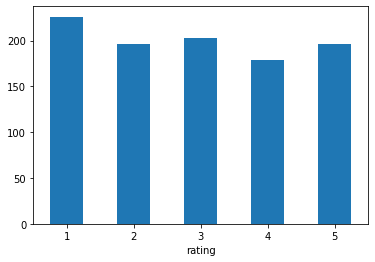

In [ ]:
# plot 1 - Analisando a quantidade de cada nota do catálogo
ft1 = df.groupby('rating').size()
ft1.plot(kind='bar',rot=0)

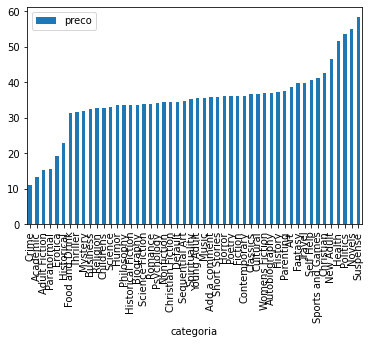

In [ ]:
# Plot2 - Média de preços dos livros por categoria
ft2 = df[['categoria','preco']]
ft2 = ft2.groupby('categoria').mean()
ft2 = ft2.sort_values('preco')
ft2.plot(kind='bar')

## Carregamento do Database Final

In [ ]:
df.to_csv('db_final.csv',index=False)

# EXTRA

Caso estivesse uma empresa quisesse que passasse o dataframe para um banco de dados, poderia-se executar o código abaixo. No caso, optou-se pelo PostgreSQL.

In [ ]:
# conn = psycopg2.connect("dbname=livros host= ip_database user=admin password=admin")

In [ ]:
#df.to_sql(db_final,con=conn, if_exists='append')